In [6]:
import tweepy
from pprint import pprint
import pandas as pd

pd.options.display.max_rows = 100

#Creacion SparkSession

from pyspark.sql import SparkSession
spark=SparkSession.builder.appName('twitter_structured_streaming').getOrCreate()
# Librerias 

import pyspark.sql.functions as F
from pyspark.sql.types import *

In [7]:
#define schema para el input data
schema=StructType().add("user_id", "string")\
.add("user_name", "string").add("text", "string")\
.add("location", "string").add("user_location","string")\
.add("user_followers_count","integer").add("user_created_at",'string')\
.add("user_count_tweets","integer").add("hashtag",'string')
schema

StructType(List(StructField(user_id,StringType,true),StructField(user_name,StringType,true),StructField(text,StringType,true),StructField(location,StringType,true),StructField(user_location,StringType,true),StructField(user_followers_count,IntegerType,true),StructField(user_created_at,StringType,true),StructField(user_count_tweets,IntegerType,true),StructField(hashtag,StringType,true)))

In [8]:
TWITTER_APP_KEY = 'RNbWRckUdr1mzMYe2ir2S44aP'
TWITTER_APP_SECRET = 'FVB0RX0nGo1VMRAMF603g7jOKuZdKfCLo0SjXWv2T15wHvLMRy'
TWITTER_KEY = '1220749681900191744-JDImKJjEF4NadKsiKekx82zDI9FyQW'
TWITTER_SECRET = 'bQaUWESSjNkqhO3d2Sc4pLPmNDYLr5DiRIIS5ko5Sg4yv'

auth = tweepy.OAuthHandler(TWITTER_APP_KEY, TWITTER_APP_SECRET)
auth.set_access_token(TWITTER_KEY, TWITTER_SECRET)

api = tweepy.API(auth)

# class StreamListener(tweepy.StreamListener):
#     def on_status(self, status):
#         print(status.text)
l = []
class StreamListener(tweepy.StreamListener):
    def on_status(self, status):
#         pprint(status._json)
        print (status.text)
        #spark.createDataFrame([(status.user.id_str, status.user.name, status.text, status.geo,status.user.location,status.user.followers_count,status.user.created_at,status.user.statuses_count)]
                              #,["user_id", "user_name" ,"text","location","user_location","user_followers_count","user_created_at","user_count_tweets"],schema=schema).write.csv("twitter_data",mode='append')  
        
        
#         data = (status.user.id_str, status.user.name, status.text, 
#                                 status.geo,status.user.location,status.user.followers_count,
#                                 status.user.created_at,status.user.statuses_count,[text['text'] for text in status.entities['hashtags']])
        for text in status.entities['hashtags']:
            data = (status.user.id_str, status.user.name, status.text, 
                                status.geo,status.user.location,status.user.followers_count,
                                status.user.created_at,status.user.statuses_count,text['text'])
            spark.createDataFrame([(data)],schema=schema).write.csv("twitter_data",mode='append')
        
    def on_error(self, status_code):
        if status_code == 420:
            return False

stream_listener = StreamListener()
stream = tweepy.Stream(auth=api.auth, listener=stream_listener)


In [9]:
stream.filter(track=["#trump", "#clinton", "#hillaryclinton", "#donaldtrump"])
# stream.filter()

#Trump @realDonaldTrump #USA #Republicans #DemocratsAreADisgrace 
#PelosiDisgrace https://t.co/kFFTGHBO1U
RT @mog7546: #DonJr just shattered the White House's flimsy justification for firing the witnesses

He thanked #Schiff for helping #Trump U…
I admit I had no idea we could fall so far so fast.
Is US politics beyond the point of repair? https://t.co/FhHXyLsOFT  #newdecade #American #thepast30years… https://t.co/2CWvKeIP8Z
This is what we’ve become. It’s actually who we’ve always been.  Scenes from #WashingtonDC yesterday. #ThisIsAmerica
RT @AndyOstroy: @realDonaldTrump Can’t say I mind the fact that you are so pathologically mentally tortured by your #ImpeachmentForLife...…
@realDonaldTrump supporters too scared to show their faces.
Cowards and traitors like #trump.
#WhiteNationalists… https://t.co/56Bq37er8m
NUEVO MEDIO SPS-8250 DE 8 PULGADAS. POTENCIA DE 450W - 8 OHM COMPRALO EN -&gt; https://t.co/WEKBXJKRgi #caraudio… https://t.co/DcS6lwxcuD
RT @Tombx7M: Your daily reminder
No on

A NINGÚN PRESIDENTE de Venezuela lo recibieron de esa manera como lo hizo #TRUMP ...para dejar las cosas en claro,… https://t.co/lo5wGdxIy5
@CB618444 @Etm114E @realDonaldTrump This would be all over the #traitor news networks 24/7 if instead the aggressor… https://t.co/ntqOR6PamF
RT @AndyOstroy: @realDonaldTrump My God, man, can you be anymore embarrassingly insecure and needy? Have you no shame? #Trump
RT @Unpersuaded112: Just speaking about his physical appearance, leaving all his stupid, selfish, ignorant traits, he looks like his face w…
RT @TiffanyDCross: Stop asking us to “understand” #Trump’s base. We understand them very well. We are bound by the intergenerational trauma…
RT @Jim_Hickman13: From someone who actually served with Vindman, &amp; is in contact w/many other soldiers who have as well, let me just say w…
#SundayThoughts: The gull of #Trump calling #Trudeau #TwoFaced!! https://t.co/8jviJ8j573
@GOP If you'd put $100 on #Trump to be re-elected, you'd receive roughly $174

KeyboardInterrupt: 

In [10]:
data=spark.readStream.option("sep", ",").schema(schema).csv("twitter_data")

In [11]:
data.printSchema()

root
 |-- user_id: string (nullable = true)
 |-- user_name: string (nullable = true)
 |-- text: string (nullable = true)
 |-- location: string (nullable = true)
 |-- user_location: string (nullable = true)
 |-- user_followers_count: integer (nullable = true)
 |-- user_created_at: string (nullable = true)
 |-- user_count_tweets: integer (nullable = true)
 |-- hashtag: string (nullable = true)



In [12]:
count = data.groupBy("user_name").count()
query = (count.writeStream.queryName('count_query').outputMode('complete').format('memory').start())
# spark.sql("select * from count_query").toPandas().head()


In [20]:
spark.sql("select * from count_query").toPandas()

,user_name,count
0,Rod,1
1,"Charlotte Carson🌊🌊🌊#blue wave,resist.",1
2,Independent Thinker,8
3,Sue,1
4,ONE DARK FOX 🦊😈☠,4
...,...,...
215,scott lowrance,10
216,🌸🌸🌸Lesa Robertson🌸🌸🌸,1
217,newsbot,3
218,James Craig,1


In [21]:
# data.show().writeStream.queryName('count_query').outputMode('complete').format('memory').start()
d = data.filter(data['user_name']!='None')
d = d.groupBy(["hashtag"]).count()
# d = data.describe(['user_followers_count']).show()
query_2 = d.writeStream.queryName('pruebaa').outputMode('complete').format('memory').start()
# d= data.writeStream.format('console').start()

In [31]:
df= spark.sql("select * from pruebaa").toPandas()

In [33]:
df

,hashtag,count
0,Cult45,1
1,Moats,1
2,TeaParty,2
3,Russia,1
4,MAGA,2
...,...,...
129,American,1
130,Parody,1
131,Politics,1
132,4MoreYears,1


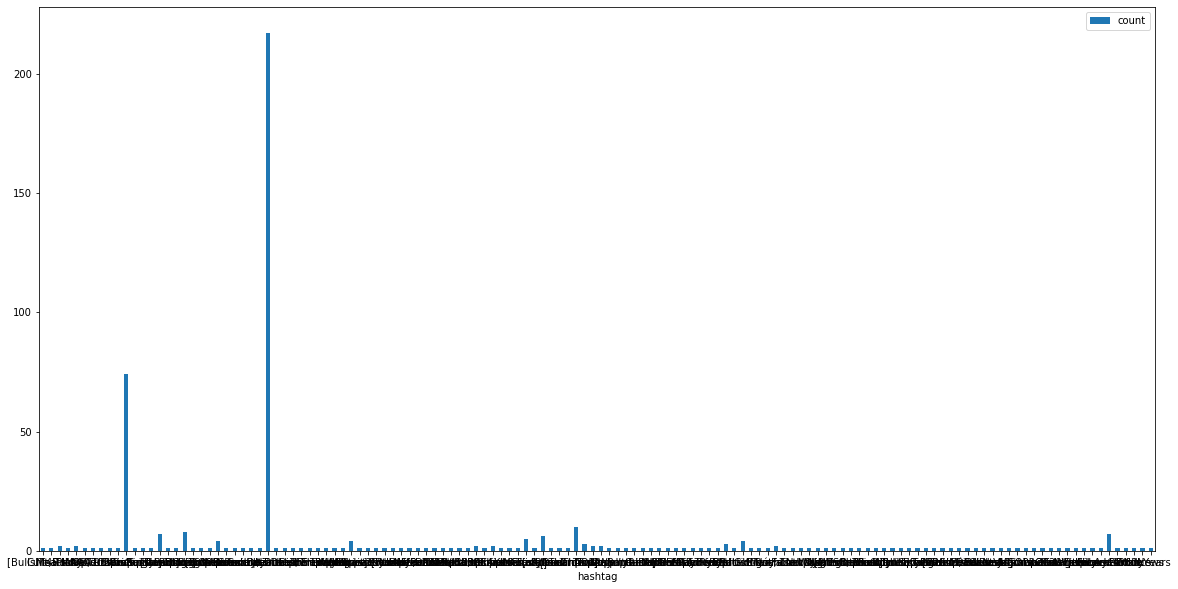

In [35]:
df.plot.bar(x='hashtag', y='count', rot=0,figsize=(20,10))

In [85]:
query_2.stop()